### Import Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
from models.custom_resnet import CustomResnet
from utils.data import train_dataset, test_dataset
from utils.training import train, test

from utils.common import (
    find_lr,
    one_cycle_lr,
    show_model_summary,
    show_img_grid,
    show_random_images,
    show_random_images_for_each_class,
    lossacc_plots,
    lr_plots,
)

Files already downloaded and verified
Files already downloaded and verified


/home/ravi.naik/miniconda3/envs/torchenv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Create Dataloaders

In [3]:
batch_size = 512
shuffle = True
num_workers = 4

In [4]:
trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

testloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

### Check Sample Images

In [5]:
images, labels = next(iter(trainloader))

In [6]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(5))

In [7]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


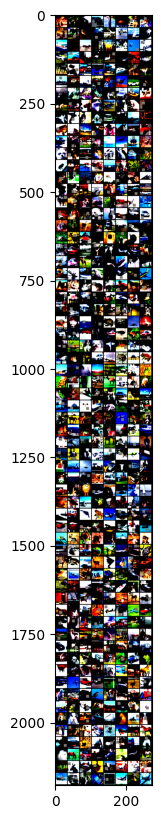

In [8]:
show_random_images(data_loader=trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


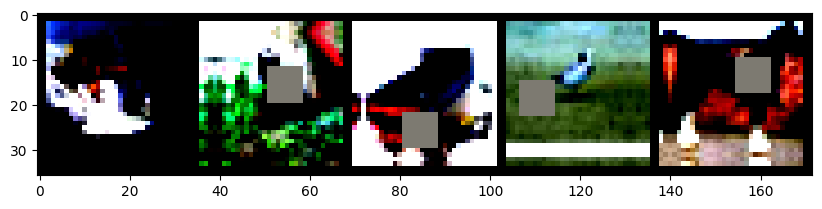

In [9]:
show_img_grid(images[25:30])

### Set Device

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
device

'cuda'

### Generate Model Summary

In [12]:
model = CustomResnet().to(device)

In [13]:
show_model_summary(model, batch_size)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CustomResnet                             [512, 3, 32, 32]          [512, 10]                 --                        --
├─Sequential: 1-1                        [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --
│    └─Conv2d: 2-1                       [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
│    └─ReLU: 2-3                         [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
├─Sequential: 1-2                        [512, 64, 32, 32]         [512, 128, 16, 16]        --                        --
│    └─Conv2d: 2-4                       [512, 64, 32, 32]         [512, 128, 32, 32]        73,728                    [3, 3]
│    └

### Declare Optimizer & Criterion

In [14]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

### Find LR

  0%|          | 0/600 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.33E-02


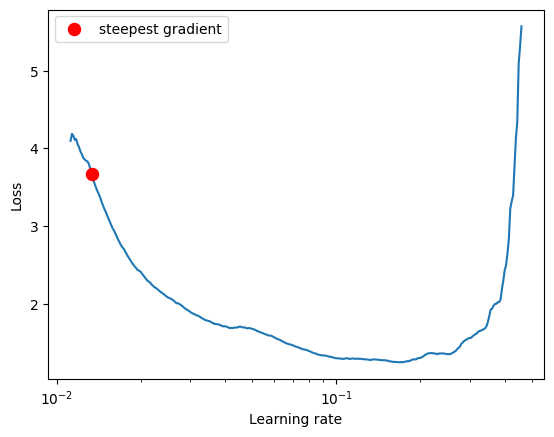

In [15]:
find_lr(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=trainloader,
    numiter=600,
    endlr=10,
    startlr=1e-2,
)

### Create the Scheduler - One Cycle Policy

In [16]:
epochs = 24
maxlr = 1.33e-02
scheduler = one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(trainloader), epochs=epochs
)

### Model Training & Evaluation

In [17]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[], lr=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc, lrs = train(
        model=model,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=trainloader,
        scheduler=scheduler,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test(
        model=model, device=device, criterion=criterion, test_loader=testloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    results["lr"].extend(lrs)
    results["epoch"].append(epoch)

Epoch: 1


Loss=1.14 Accuracy=52.49: 100%|██████████| 98/98 [00:06<00:00, 15.59it/s]



Test set: Average loss: 1.1930, Accuracy: 6043/10000 (60.43%)

Epoch: 2


Loss=0.85 Accuracy=69.56: 100%|██████████| 98/98 [00:06<00:00, 15.71it/s]



Test set: Average loss: 0.8313, Accuracy: 7153/10000 (71.53%)

Epoch: 3


Loss=0.77 Accuracy=76.28: 100%|██████████| 98/98 [00:06<00:00, 15.60it/s]



Test set: Average loss: 0.8783, Accuracy: 7214/10000 (72.14%)

Epoch: 4


Loss=0.67 Accuracy=77.35: 100%|██████████| 98/98 [00:06<00:00, 16.02it/s]



Test set: Average loss: 0.8774, Accuracy: 7278/10000 (72.78%)

Epoch: 5


Loss=0.53 Accuracy=80.10: 100%|██████████| 98/98 [00:06<00:00, 15.59it/s]



Test set: Average loss: 0.8270, Accuracy: 7361/10000 (73.61%)

Epoch: 6


Loss=0.52 Accuracy=82.46: 100%|██████████| 98/98 [00:06<00:00, 15.71it/s]



Test set: Average loss: 0.7742, Accuracy: 7526/10000 (75.26%)

Epoch: 7


Loss=0.57 Accuracy=84.16: 100%|██████████| 98/98 [00:06<00:00, 15.59it/s]



Test set: Average loss: 0.6349, Accuracy: 7935/10000 (79.35%)

Epoch: 8


Loss=0.38 Accuracy=85.74: 100%|██████████| 98/98 [00:06<00:00, 15.73it/s]



Test set: Average loss: 0.6734, Accuracy: 7939/10000 (79.39%)

Epoch: 9


Loss=0.34 Accuracy=86.58: 100%|██████████| 98/98 [00:06<00:00, 15.88it/s]



Test set: Average loss: 0.4385, Accuracy: 8505/10000 (85.05%)

Epoch: 10


Loss=0.31 Accuracy=87.36: 100%|██████████| 98/98 [00:06<00:00, 15.57it/s]



Test set: Average loss: 0.4432, Accuracy: 8516/10000 (85.16%)

Epoch: 11


Loss=0.33 Accuracy=88.40: 100%|██████████| 98/98 [00:06<00:00, 15.56it/s]



Test set: Average loss: 0.4435, Accuracy: 8529/10000 (85.29%)

Epoch: 12


Loss=0.32 Accuracy=88.59: 100%|██████████| 98/98 [00:06<00:00, 15.47it/s]



Test set: Average loss: 0.4203, Accuracy: 8619/10000 (86.19%)

Epoch: 13


Loss=0.39 Accuracy=88.89: 100%|██████████| 98/98 [00:06<00:00, 15.68it/s]



Test set: Average loss: 0.4688, Accuracy: 8457/10000 (84.57%)

Epoch: 14


Loss=0.27 Accuracy=89.42: 100%|██████████| 98/98 [00:06<00:00, 15.53it/s]



Test set: Average loss: 0.3750, Accuracy: 8721/10000 (87.21%)

Epoch: 15


Loss=0.29 Accuracy=90.32: 100%|██████████| 98/98 [00:06<00:00, 15.94it/s]



Test set: Average loss: 0.4559, Accuracy: 8509/10000 (85.09%)

Epoch: 16


Loss=0.35 Accuracy=90.64: 100%|██████████| 98/98 [00:06<00:00, 15.68it/s]



Test set: Average loss: 0.4183, Accuracy: 8691/10000 (86.91%)

Epoch: 17


Loss=0.27 Accuracy=91.29: 100%|██████████| 98/98 [00:06<00:00, 15.90it/s]



Test set: Average loss: 0.3355, Accuracy: 8872/10000 (88.72%)

Epoch: 18


Loss=0.23 Accuracy=92.35: 100%|██████████| 98/98 [00:06<00:00, 15.55it/s]



Test set: Average loss: 0.3463, Accuracy: 8909/10000 (89.09%)

Epoch: 19


Loss=0.22 Accuracy=92.80: 100%|██████████| 98/98 [00:06<00:00, 15.57it/s]



Test set: Average loss: 0.3344, Accuracy: 8929/10000 (89.29%)

Epoch: 20


Loss=0.16 Accuracy=93.57: 100%|██████████| 98/98 [00:06<00:00, 15.52it/s]



Test set: Average loss: 0.2818, Accuracy: 9109/10000 (91.09%)

Epoch: 21


Loss=0.13 Accuracy=94.65: 100%|██████████| 98/98 [00:06<00:00, 15.62it/s]



Test set: Average loss: 0.2523, Accuracy: 9196/10000 (91.96%)

Epoch: 22


Loss=0.10 Accuracy=95.66: 100%|██████████| 98/98 [00:06<00:00, 15.62it/s]



Test set: Average loss: 0.2638, Accuracy: 9151/10000 (91.51%)

Epoch: 23


Loss=0.09 Accuracy=96.67: 100%|██████████| 98/98 [00:06<00:00, 15.97it/s]



Test set: Average loss: 0.2254, Accuracy: 9272/10000 (92.72%)

Epoch: 24


Loss=0.05 Accuracy=97.47: 100%|██████████| 98/98 [00:06<00:00, 15.49it/s]



Test set: Average loss: 0.2142, Accuracy: 9328/10000 (93.28%)



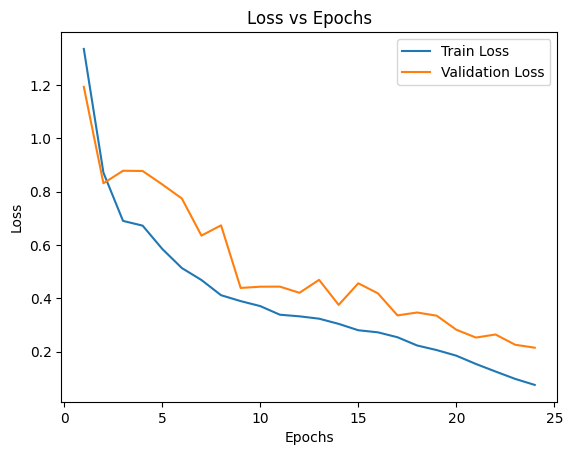

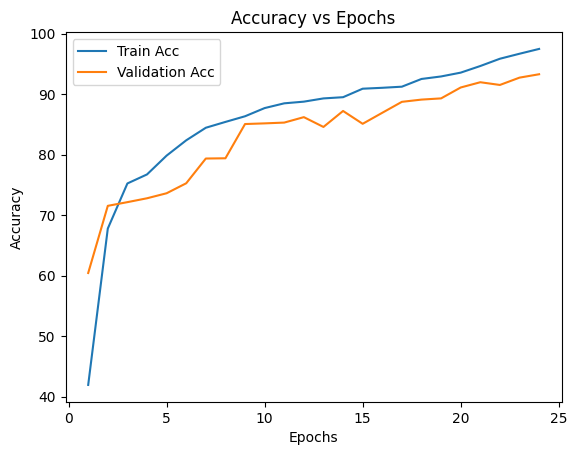

In [18]:
lossacc_plots(results)

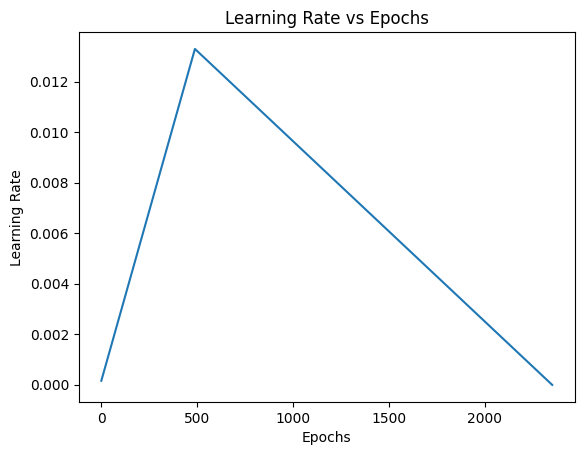

In [19]:
lr_plots(results, length=len(trainloader) * epochs)